In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/hackaton_2023/default.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from skimage.io import imread
import os
from pathlib import Path
from PIL import Image

from time import time
from IPython.display import clear_output

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
images = []
segm = []
images_dir = Path('/content/image_2')
segm_dir = Path('/content/instance')

images = list(images_dir.rglob('*.jpg'))
segm = list(segm_dir.rglob('*.png'))
print(len(images))
print(len(segm))

1940
1940


In [ ]:
class RoadDataset(Dataset):
  def __init__(self, images, segm):
    super().__init__()
    self.images = sorted(images)
    self.segm = sorted(segm)

    self.len_ = len(self.images)

  def __len__(self):
    return self.len_

  def load_sample(self, img_path, segm_path):
        image = Image.open(img_path).convert('L')
        segm = Image.open(segm_path).convert('L')
        image.load()
        segm.load()
        return image, segm

  def __getitem__(self, index):
    x, y = self.load_sample(self.images[index], self.segm[index])
    x = self._prepare_sample(x)
    y = self._prepare_sample(y)
    x = np.array(x / 255, dtype='float32')
    y = np.array(y < 200, dtype='float32')

    return torch.from_numpy(x), torch.from_numpy(y)

  def _prepare_sample(self, image):
    #RESCALE_SIZE = 256
    image = image.resize((512, 512))
    return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from sklearn.model_selection import train_test_split

data = RoadDataset(images, segm)

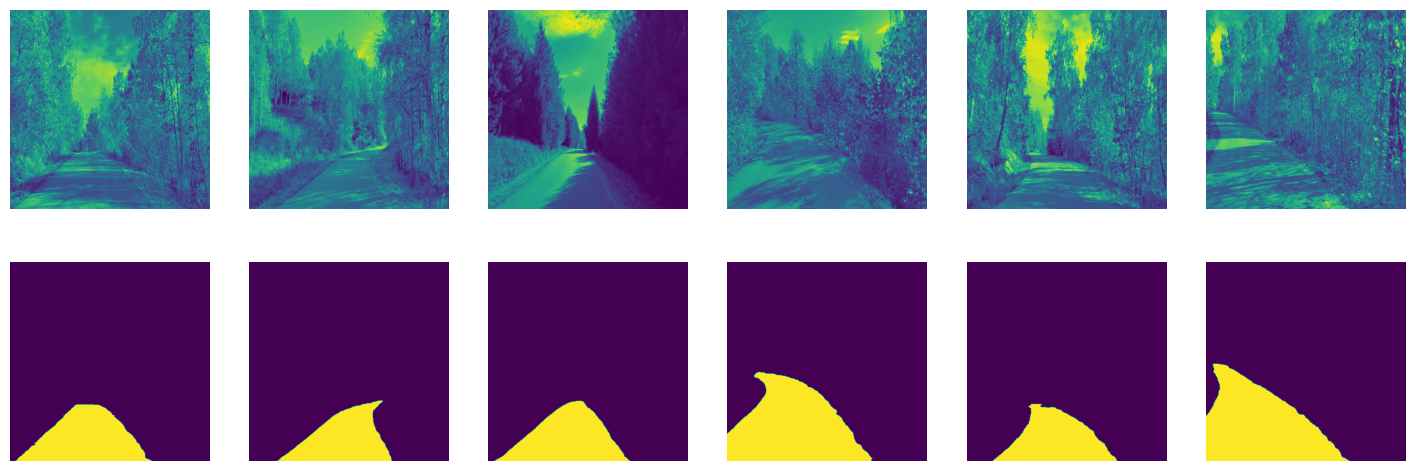

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    random_index = int(np.random.uniform(0,100))
    img, segm = data[random_index]
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(img)

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(segm)
plt.show();

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        # C 32 -> 64 -> 128 -> 256 -> bottleneck -> 512 -> 256
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size = 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size = 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size = 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size = 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size = 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size = 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size = 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size = 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size = 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size = 3, padding=1),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size = 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size = 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size = 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size = 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size = 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size = 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(2)  # 128 -> 256
        self.dec_conv3 =nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size = 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size = 1)
        )

    def forward(self, x):
        # encoder
        x = x[:, None, :, :]
        e0 = self.enc_conv0(x)
        p0, ind0 = self.pool0(e0)

        e1 = self.enc_conv1(p0)
        p1, ind1 = self.pool1(e1)

        e2 = self.enc_conv2(p1)
        p2, ind2 = self.pool2(e2)

        e3 = self.enc_conv3(p2)
        p3, ind3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(p3)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b, ind3), e3), dim = 1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0, ind2), e2), dim = 1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1, ind1), e1), dim = 1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2, ind0), e0), dim = 1))   # no activation

        return d3

In [ ]:
def bce_loss(y_real, y_pred):
    y_pred = y_pred[:, None, :, :]
    out = torch.maximum(y_pred, torch.zeros(y_pred.size()).to(device))
    out = out - y_pred * y_real
    out = out + torch.log(1 + torch.exp(-abs(y_pred)))
    return out.mean()

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(y_pred, min = 0, max = 1) # hint: torch.clamp
    y_pred = y_pred[:, 0, :, :]
    out = torch.pow(1 - torch.sigmoid(y_pred), gamma) * y_real * torch.log(torch.sigmoid(y_pred))
    out = out + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred))
    return -(out).sum((1, 2)).mean()

In [ ]:
model = UNet().to(device)

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [ ]:
def train(model, opt, loss_fn, epochs, data):
    history_train = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        train_history = avg_loss.detach().cpu()
        history_train.append(train_history)
    return history_train

In [ ]:
dataloader = DataLoader(data, batch_size=10, shuffle=True, drop_last=True)

In [ ]:
optim.lr = 1e-5

In [ ]:
train(model, optim, bce_loss, 10, dataloader)

* Epoch 1/10
loss: 0.359800
* Epoch 2/10
loss: 0.359659
* Epoch 3/10
loss: 0.359867
* Epoch 4/10
loss: 0.357740
* Epoch 5/10
loss: 0.356370
* Epoch 6/10
loss: 0.355927
* Epoch 7/10
loss: 0.354584
* Epoch 8/10
loss: 0.354337
* Epoch 9/10
loss: 0.352909
* Epoch 10/10
loss: 0.351690


[tensor(0.3598),
 tensor(0.3597),
 tensor(0.3599),
 tensor(0.3577),
 tensor(0.3564),
 tensor(0.3559),
 tensor(0.3546),
 tensor(0.3543),
 tensor(0.3529),
 tensor(0.3517)]

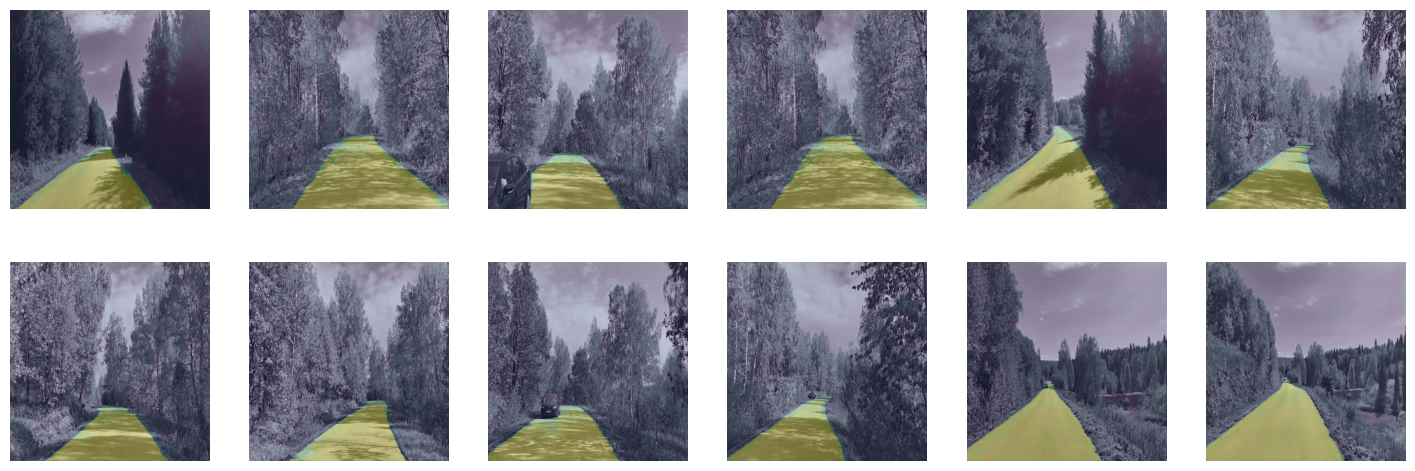

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(12):
    random_index = int(np.random.uniform(0,100))
    img, _ = data[random_index]
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(img, cmap='gray')

    plt.subplot(2, 6, i+1)
    plt.axis("off")
    segm = img[None, :, :].to(device)
    segm = model(segm)
    segm = segm[0, :, :, :].permute(1, 2, 0)
    segm = torch.sigmoid(segm)
    plt.imshow(segm.cpu().detach().numpy(), alpha = 0.3)
plt.show();

In [ ]:
torch.save(model.state_dict(), "/content/model")
#model.load_state_dict(torch.load("/content/model (4)"))